In [55]:
from sweepai.config.client import SweepConfig
from sweepai.core.lexical_search import prepare_lexical_search_index
from sweepai.utils.github_utils import ClonedRepo, MockClonedRepo


cloned_repo = MockClonedRepo(
    "/tmp/sweep",
    "sweepai/sweep",
)

_, snippets, lexical_index = prepare_lexical_search_index(
    cloned_repo.cached_dir,
    SweepConfig(),
)

In [56]:
from sweepai.core.lexical_search import SNIPPET_FORMAT
from sweepai.core.vector_db import embed_text_array

snippet_formats = [
    SNIPPET_FORMAT.format(
        file_path=snippet.file_path,
        contents=snippet.get_snippet(add_ellipsis=False, add_lines=False),
    ) for snippet in snippets
]

embeddings = embed_text_array(snippet_formats)

openai embedding:   0%|          | 0/3 [00:00<?, ?it/s]

openai embedding: 100%|██████████| 3/3 [00:00<00:00, 15.35it/s]


In [57]:
import numpy as np

embeddings = np.concatenate(embeddings, axis=0)

In [58]:
embeddings, embeddings.shape

(array([[-0.02411441, -0.02171271,  0.05348661, ...,  0.03586329,
         -0.02171271, -0.00821123],
        [ 0.0182037 ,  0.02335203,  0.05350372, ...,  0.04868567,
         -0.04487785, -0.0305014 ],
        [-0.05113083, -0.00523904,  0.08606402, ...,  0.03495184,
         -0.06658205, -0.03491452],
        ...,
        [-0.09475309, -0.01271244,  0.0428106 , ...,  0.00565865,
         -0.00643427, -0.04768874],
        [-0.07259093,  0.00631516,  0.03578078, ...,  0.05537992,
          0.00829669, -0.02684588],
        [ 0.03295828, -0.04015078,  0.0591305 , ...,  0.01009071,
         -0.02944155, -0.04382655]]),
 (546, 512))

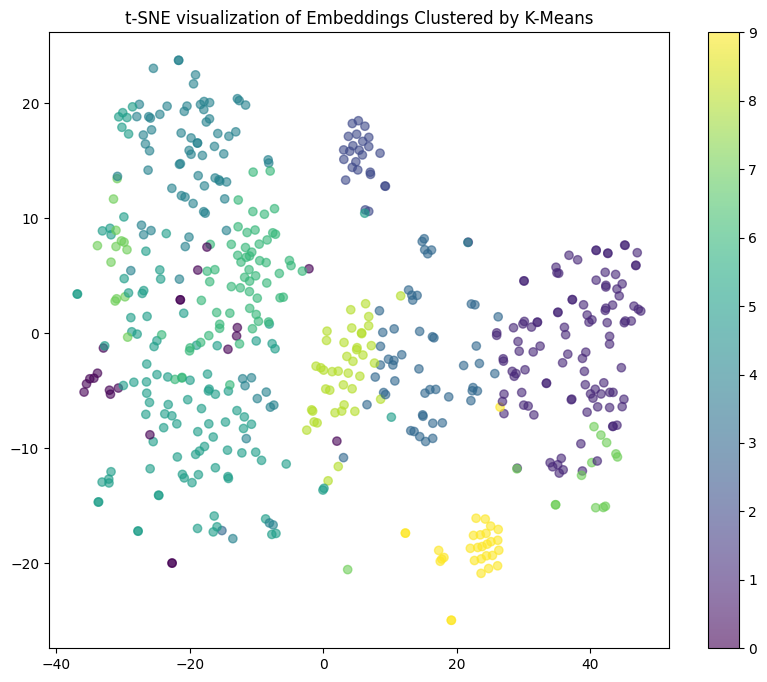

In [59]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of Embeddings Clustered by K-Means')
plt.show()

In [60]:
cluster_indices = {}
for i in range(kmeans.n_clusters):
    cluster_indices[i] = np.where(clusters == i)[0]

for cluster, indices in cluster_indices.items():
    print(f"Cluster {cluster}")
    count = 0
    vis_file_path = set()
    for index in indices:
        if count == 20:
            break
        if snippets[index].file_path in vis_file_path:
            continue
        vis_file_path.add(snippets[index].file_path)
        print(snippets[index].file_path.removeprefix(cloned_repo._repo_dir + "/"))
        count += 1
    print("\n")
    

Cluster 0
docs/pages/blogs/openai-proxy.mdx
docs/public/redis_vector_db.py
docs/sdk/src/agent.py
sweepai/core/vector_db.py
sweepai/core/chat.py
sweepai/utils/chat_logger.py
sweepai/utils/openai_proxy_test.py
sweepai/utils/progress.py
sweepai/utils/event_logger.py
sweepai/utils/openai_proxy.py
sweepai/utils/anthropic_client.py
sweepai/chat/api.py
sweepai/config/server.py
sweepai/agents/agent_utils.py
sweepai/agents/assistant_wrapper.py
sweepai/agents/image_description_bot.py
tests/notebooks/src/mod3.py
tests/archive/test_api.py
sweep_chat/backend/api.py


Cluster 1
package.json
docs/package.json
docs/theme.config.tsx
docs/pages/_app.tsx
docs/pages/blogs/index.mdx
docs/components/counters.module.css
docs/components/counters.tsx
docs/components/PRPreview.jsx
docs/components/RepoPreview.jsx
docs/components/Cards.tsx
docs/components/ShowMore.jsx
docs/tailwind.config.js
docs/tsconfig.json
docs/next-env.d.ts
docs/styles/global.css
docs/next.config.js
tests/archive/test_modify_bot.py
platform/

In [71]:
import os

def count_files(directory):
    total_count = 0
    for root, dirs, files in os.walk(directory):
        total_count += len(files)
    return total_count

def find_large_subdirs(directory, file_threshold):
    large_subdirs = []
    for root, dirs, files in os.walk(directory):
        if ".git" in root.split(os.sep):
            continue
        subdir_file_count = count_files(root)
        if subdir_file_count > file_threshold:
            large_subdirs.append(root)
    large_subdirs.remove(directory)
    return large_subdirs


# Usage: Specify the directory path and the file threshold
directory_path = cloned_repo._repo_dir
file_threshold = 10
large_subdirectories = find_large_subdirs(directory_path, file_threshold)
print("Subdirectories with more than 20 files:", large_subdirectories)

Subdirectories with more than 20 files: ['/tmp/sweep/docs', '/tmp/sweep/docs/pages', '/tmp/sweep/docs/pages/blogs', '/tmp/sweep/docs/public', '/tmp/sweep/docs/public/deployment', '/tmp/sweep/docs/public/covers', '/tmp/sweep/sweepai', '/tmp/sweep/sweepai/core', '/tmp/sweep/sweepai/utils', '/tmp/sweep/sweepai/agents', '/tmp/sweep/tests', '/tmp/sweep/tests/notebooks', '/tmp/sweep/tests/jsons', '/tmp/sweep/tests/events', '/tmp/sweep/tests/archive', '/tmp/sweep/platform', '/tmp/sweep/platform/components', '/tmp/sweep/platform/components/ui', '/tmp/sweep/platform/components/dashboard', '/tmp/sweep/platform/lib', '/tmp/sweep/platform/app', '/tmp/sweep/sweep_chat', '/tmp/sweep/sweep_chat/components', '/tmp/sweep/sweep_chat/components/ui', '/tmp/sweep/.github']


In [74]:
large_subdirectory = large_subdirectories[0]
snippets_in_subdir = []
embeddings_in_subdir = []

for i, snippet in enumerate(snippets):
    if snippet.file_path.startswith(large_subdirectory):
        snippets_in_subdir.append(snippet)
        embeddings_in_subdir.append(embeddings[i])

print(snippets_in_subdir)
print(embeddings_in_subdir)


[Snippet(start=0, end=19, file_path='/tmp/sweep/docs/Recipes.md', score=0.0), Snippet(start=0, end=66, file_path='/tmp/sweep/docs/package.json', score=0.0), Snippet(start=0, end=52, file_path='/tmp/sweep/docs/theme.config.tsx', score=0.0), Snippet(start=0, end=137, file_path='/tmp/sweep/docs/pages/assistant.mdx', score=0.0), Snippet(start=0, end=37, file_path='/tmp/sweep/docs/pages/_meta.json', score=0.0), Snippet(start=0, end=18, file_path='/tmp/sweep/docs/pages/_app.tsx', score=0.0), Snippet(start=0, end=133, file_path='/tmp/sweep/docs/pages/cli.mdx', score=0.0), Snippet(start=0, end=6, file_path='/tmp/sweep/docs/pages/about/_meta.json', score=0.0), Snippet(start=0, end=11, file_path='/tmp/sweep/docs/pages/about/limitations.mdx', score=0.0), Snippet(start=0, end=62, file_path='/tmp/sweep/docs/pages/about/examples.mdx', score=0.0), Snippet(start=0, end=7, file_path='/tmp/sweep/docs/pages/about/roadmap.mdx', score=0.0), Snippet(start=0, end=200, file_path='/tmp/sweep/docs/pages/deploym

In [82]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

def select_diverse_vectors(vectors, num_vectors=5):
    # Start with a random vector
    selected_indices = [np.random.randint(len(vectors))]
    selected_vectors = [vectors[selected_indices[0]]]
    
    for _ in range(1, num_vectors):
        max_min_distance = 0
        next_index = -1
        
        for i in range(len(vectors)):
            if i in selected_indices:
                continue
            
            # Calculate minimum distance to all selected vectors
            distances = cosine_distances([vectors[i]], selected_vectors)[0]
            min_distance = np.min(distances)
            
            # Select the vector that maximizes the minimum distance
            if min_distance > max_min_distance:
                max_min_distance = min_distance
                next_index = i
        
        selected_indices.append(next_index)
        selected_vectors.append(vectors[next_index])
    
    return selected_indices

# Example usage
# Assuming 'embeddings' is your list of embeddings
indices = select_diverse_vectors(embeddings_in_subdir)
diverse_snippets = [snippets_in_subdir[i] for i in indices]
diverse_vectors = [embeddings_in_subdir[i] for i in indices]
print(diverse_snippets)

[Snippet(start=0, end=107, file_path='/tmp/sweep/docs/public/file_cache.py', score=0.0), Snippet(start=0, end=118, file_path='/tmp/sweep/docs/components/Cards.tsx', score=0.0), Snippet(start=0, end=4, file_path='/tmp/sweep/docs/sdk/README.md', score=0.0), Snippet(start=0, end=200, file_path='/tmp/sweep/docs/pages/blogs/chunking-2m-files.mdx', score=0.0), Snippet(start=0, end=133, file_path='/tmp/sweep/docs/public/redis_vector_db.py', score=0.0)]


In [89]:
from sweepai.core.vector_db import cosine_similarity


def find_central_vectors(vectors, num_vectors=5):
    # Calculate the centroid of all vectors
    centroid = np.mean(vectors, axis=0)
    
    # Compute cosine similarities between each vector and the centroid
    similarities = cosine_similarity(vectors, [centroid]).flatten()
    
    # Get indices of the top 'num_vectors' vectors with highest similarity
    central_indices = np.argsort(-similarities)[:num_vectors]
    
    return central_indices

# Example usage
# Assuming 'embeddings' is your list of embeddings
central_indices = find_central_vectors(np.array(embeddings_in_subdir))
central_snippets = [snippets[i] for i in central_indices]
central_vectors = [embeddings[i] for i in central_indices]
for snippet in central_snippets:
    print(snippet.denotation + "\n\n")
    print(snippet.get_snippet(False, False))

/tmp/sweep/docs/pages/usage/tutorial.mdx:0-68


import { Steps } from 'nextra/components'

# Tutorial for Getting Started with Sweep

We recommend using an existing **real project** for Sweep, but if you must start from scratch for testing, we recommend **using a template**. In particular, we recommend Vercel templates and Vercel auto-deploy, since Vercel's auto-generated previews make it **easy to review Sweep's PRs**

We'll use [Docusaurus](https://vercel.com/templates/next.js/docusaurus-2) for this tutorial since it's is the easiest to set up.

<Steps>

### Fork and deploy a Docusaurus template

Go to https://vercel.com/templates/next.js/docusaurus-2 (or another template) and click "Deploy".

![Deploy](/tutorial/deployment.png)

Vercel will prompt you to select a GitHub account and click "Clone" after. This will trigger a build and deploy which will take a few minutes. Once the build is done, you will be greeted with a congratulations message.

![Congratulations](/tutorial/congratul

In [118]:
def count_descendants(directory):
    descendant_count = {}

    def dfs(current_dir):
        count = 0
        for root, dirs, files in os.walk(current_dir):
            if ".git" in root.split(os.sep):
                continue
            for d in dirs:
                if ".git" in root.split(os.sep):
                    continue
                count += dfs(os.path.join(root, d))
            count += len(files)
        descendant_count[current_dir.removeprefix(directory.rstrip() + "/")] = count
        return count

    dfs(directory)
    for key in (".git", "", directory):
        if key in descendant_count:
            del descendant_count[key]
    return descendant_count

directory_path = cloned_repo._repo_dir
descendants = count_descendants(directory_path)
print(descendants)

{'docs/pages/about': 4, 'docs/pages/usage': 6, 'docs/pages/blogs': 24, 'docs/pages/videos': 6, 'docs/pages': 90, 'docs/components': 6, 'docs/public/sweep-core-algo': 8, 'docs/public/modification': 1, 'docs/public/deployment': 18, 'docs/public/assistant': 1, 'docs/public/openai_proxy': 5, 'docs/public/covers': 22, 'docs/public/trunk': 1, 'docs/public/assets/tutorial': 6, 'docs/public/assets': 16, 'docs/public/tutorial': 9, 'docs/public/flowchart': 4, 'docs/public': 184, 'docs/styles': 1, 'docs/sdk/src': 2, 'docs/sdk': 6, 'docs/.github': 1, 'docs': 588, 'sweepai/core': 16, 'sweepai/logn': 5, 'sweepai/handlers': 10, 'sweepai/web': 5, 'sweepai/utils': 52, 'sweepai/chat': 1, 'sweepai/config': 3, 'sweepai/agents': 15, 'sweepai': 221, 'tests/perf': 2, 'tests/e2e': 5, 'tests/modify_tests': 2, 'tests/notebooks/src/helpers': 2, 'tests/notebooks/src': 11, 'tests/notebooks': 33, 'tests/search': 1, 'tests/jsons': 12, 'tests/events': 36, 'tests/archive': 55, 'tests': 308, '.assets': 6, 'platform/cyp

In [119]:
def print_sorted_descendants(directory):
    descendants = count_descendants(directory)
    # Sort directories by the number of files, from highest to lowest
    sorted_descendants = sorted(descendants.items(), key=lambda item: item[1], reverse=True)
    for dir_path, count in sorted_descendants:
        print(f"{dir_path}: {count}")
print("Sorted descendants:")
print_sorted_descendants(directory_path)

Sorted descendants:
docs: 588
platform: 345
tests: 308
sweepai: 221
docs/public: 184
sweep_chat: 95
docs/pages: 90
platform/components: 73
platform/app: 64
tests/archive: 55
sweepai/utils: 52
tests/events: 36
tests/notebooks: 33
platform/app/api: 30
sweep_chat/components: 25
docs/pages/blogs: 24
docs/public/covers: 22
.github: 21
platform/components/ui: 20
docs/public/deployment: 18
docs/public/assets: 16
sweepai/core: 16
platform/components/dashboard: 16
sweepai/agents: 15
tests/jsons: 12
platform/lib: 12
sweep_chat/app: 12
tests/notebooks/src: 11
sweep_chat/components/ui: 11
bin: 11
sweepai/handlers: 10
docs/public/tutorial: 9
docs/public/sweep-core-algo: 8
platform/cypress: 8
.github/workflows: 8
platform/app/api/files: 7
docs/pages/usage: 6
docs/pages/videos: 6
docs/components: 6
docs/public/assets/tutorial: 6
docs/sdk: 6
.assets: 6
platform/app/api/openai: 6
docs/public/openai_proxy: 5
sweepai/logn: 5
sweepai/web: 5
tests/e2e: 5
platform/components/dashboard/sections: 5
docs/pages

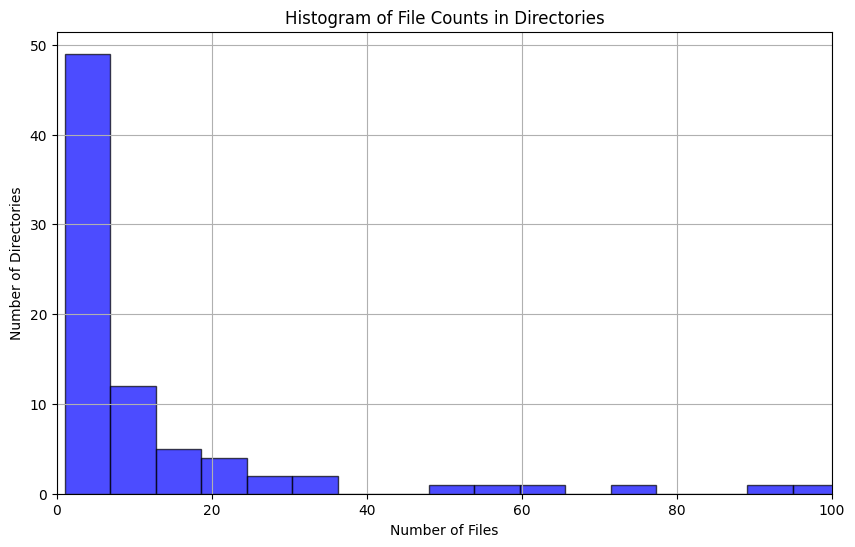

In [135]:
def plot_histogram(directory):
    file_counts = count_descendants(directory)
    values = list(file_counts.values())

    bins = list(range(0, 101))  # Bins from 0 to 100
    bins.append(max(values) + 1)  # Additional bin for all values greater than 100

    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=100, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Histogram of File Counts in Directories')
    plt.xlabel('Number of Files')
    plt.ylabel('Number of Directories')
    plt.xlim(0, 100)
    
    plt.grid(True)
    plt.show()

# Example usage:
directory_path = cloned_repo._repo_dir
plot_histogram(directory_path)